# Predict lumber prices with Ready Signal and time series forecasts

Authors: Jack Claucherty <jack.claucherty@rxa.io>, Jenna King <jenna.king@rxa.io>, Baylen Springer <baylen.springer@readysignal.com>, Matt Schaefer <matt.schaefer@readysignal.com>, Chen Wang <chen.wang@datarobot.com>

Version Date: May 17th, 2023

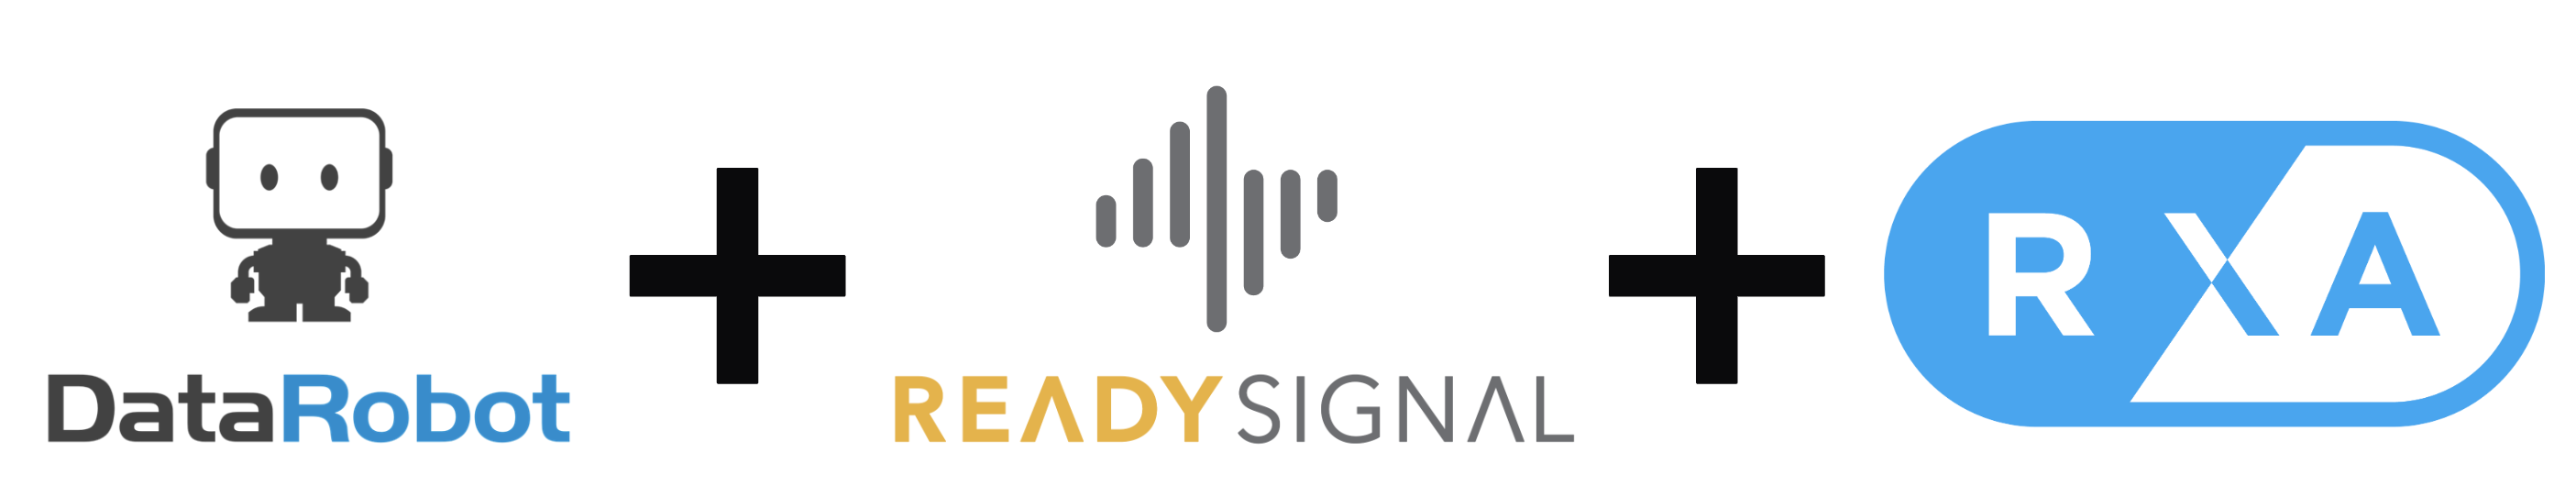

## Overview

This notebook guides you through the process of using Ready Signal to add external control data, such as census and weather data, to improve time series predictions. It outlines is an example of how to add external data to your time series dataset, create a DataRobot project, and make predictions using DataRobot and Ready Signal.

External control data can have a massive impact on the quality of your machine learning models. By incorporating these external factors, you allow the model to understand the world it is operating in. This can help the model provide better predictions and give users more context about the external forces driving the predictions. Many companies and models do not use external features as they can be difficult to acquire and maintain, and this is where Ready Signal may be leveraged.

[Ready Signal](https://readysignal.com/platform/) is an AI-powered data platform that provides access to over 500 normalized, aggregated, and automatically updated data sources for predictive modeling, experimentation, business intelligence, and other data enrichment needs. The data catalog includes micro- and macro-economic indicators, labor statistics, demographics, weather, and more. Its AI recommendation engine and auto feature engineering capabilities make it easy to integrate with existing data pipelines and analytics tooling, accelerating and enhancing how relevant third-party data is leveraged.

Ready Signal's AutoDiscovery feature automatically compares your target variable to the 500+ control features within Ready Signal. It identifies the features that are most strongly correlated with the target and selects the top 20. These variables are then used to create a "signal". When you make an API call, you will receive a signal ID that you can use to retrieve the variables.

You can create your own signal by manually selecting features within the Ready Signal platform. In this case, you may choose to skip the AutoDiscovery and import data using the signal ID from your manually generated list of variables.

The goal of this AI Accelerator is to create a workflow of bringing external features to join the core training dataset. If additional features result in improved model performance, DataRobot recommends moving on to the [End-to-End Demand Forecasting AI Accelerator](https://github.com/datarobot-community/ai-accelerators/blob/main/end-to-end/End_to_end_demand_forecasting/End_to_end_demand_forecasting.ipynb) to continue improving your modeling workflow and utilizing more DataRobot features.

### Reference

Reference the [Ready Signal API documentation](https://readysignal.com/ready-signal-api-documentation) for information about the platform.

For more information about this workflow please contact Baylen Springer <baylen.springer@readysignal.com> and Matt Schaefer <matt.schaefer@readysignal.com>.

### Learning objectives

1. Connect to DataRobot and retrieve data
2. Understand how to use Ready Signal
    2.1 Create a signal with Auto Discovery
    2.2 Create a signal using the GUI
3. Explore and edit your signal
4. Join Ready Signal data with your time series data
5. Create a time series project with the new data
6. Create a scoring dataset with Ready Signal for predictions

## Setup

### Install and import libraries

In [2]:
!pip3 install readysignal
# !pip3 install datarobot

In [3]:
import readysignal as rs
import pandas as pd
import datarobot as dr

import matplotlib.pyplot as plt
import seaborn as sns

print('Client version:', dr.__version__)

Client version: 3.1.0


### Connect to DataRobot

To connect to DataRobot, you need to provide your API key and the endpoint. For more information about finding your API key and connecting to DataRobot, reference DataRobot's [API Quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html#create-a-datarobot-api-key).

Note that your endpoint and API key are not required when you are using DataRobot Notebooks.

In [ ]:
api_key = "" # Get this from the Developer Tools page in the DataRobot UI
endpoint = "https://app.datarobot.com/" # This should be the URL you use to access the DataRobot UI

dr.Client(endpoint="%sapi/v2" % (endpoint), token=api_key)

# Set these to empty strings to create a new project and/or deployment
project_id = ""
deployment_id = ""

### Import data

This script assumes you have a dataset ready for time series analysis in DataRobot. You can also import a local file or use any other data connectors here to bring data in.

In [ ]:
# Read in training data from S3, and upload it to the AI Catalog
ts_forecasting_train = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/autoDisco/autoDisco_USLumberPrice_train.csv')

raw_dataset = dr.Dataset.upload(ts_forecasting_train)

# Get a new dataset ID from the AI Catalog and rename it
raw_dataset_id = raw_dataset.id
dr.models.Dataset.get(raw_dataset_id).modify(name='USLumberPrice')

# You can read the dataset from AI Catalog if you already uploaded the dataset before
# raw_dataset_id = '6462a7a099f708e3c6450ff5'
# ts_forecasting_train = dr.models.Dataset.get(raw_dataset_id).get_as_dataframe()

ts_forecasting_train.head()

,Date,US Lumber Price
0,7/1/2019,404.6
1,7/2/2019,391.3
2,7/3/2019,384.3
3,7/5/2019,386.2
4,7/8/2019,379.4


## How to use Ready Signal

To start using Ready Signal and add external data to your training dataset, you need to create a 'Signal'. A signal is a list of features to be used. There are two primary ways to build a signal: 

1. Use Auto Discovery, in which you give your target and date to Ready Signal and it automatically finds the best features to use.
2. Use the Ready Signal UI to manually select the features you want in your signal. 

Both options are shown below. If you choose to use Auto Discovery you can still edit the output signal and add or remove any other Ready Signal features.

In [ ]:
# Use the timestamp feature and target in the original dataset to find signal in external data from Ready Signal
# In this case, the original dataset only have two columns, which are timestamp and target, so you can skip this step
# If you have more than two columns, you will have to remove all other columns except the timestamp and target
date_feature = 'Date'
target = 'US Lumber Price'


df_rs  = ts_forecasting_train[[date_feature,target]]
df_rs[date_feature]= pd.to_datetime(df_rs[date_feature])

In [ ]:
# The Ready Signal access token is associated with your Ready Signal account

access_token = "token_value"

### Create a signal with Auto Discovery

To create a signal with Auto Discovery, send a dataset with a date feature and the target to Ready Signal using the API call in the following cell. You can select a `date_grain` of Daily or Monthly and `geo_grain` of Country or State. If you choose State for the `geo_grain`, you must also send a "state" feature along with your data. You can learn more about the Ready Signal API in its [documentation](https://readysignal.com/ready-signal-api-documentation).

In [ ]:
autoDiscovery_createSignal = rs.auto_discover(access_token, geo_grain='Country', df=df_rs, date_grain='Day')

{'message': 'Your signal has been created', 'signal_id': 1694}


### Create a signal using the GUI

Below are the steps to manually create a signal. You can start from scratch or start from a template based on your industry. Once you create your signal you can use the signal ID to grab the data via the API.

To get started, click **Create A Signal** in the top-right of the page.

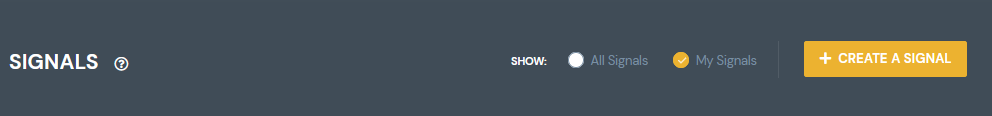

#### Configure the signal

Provide a name and description for the signal you are creating. Note that these are only used for descriptive purposes.

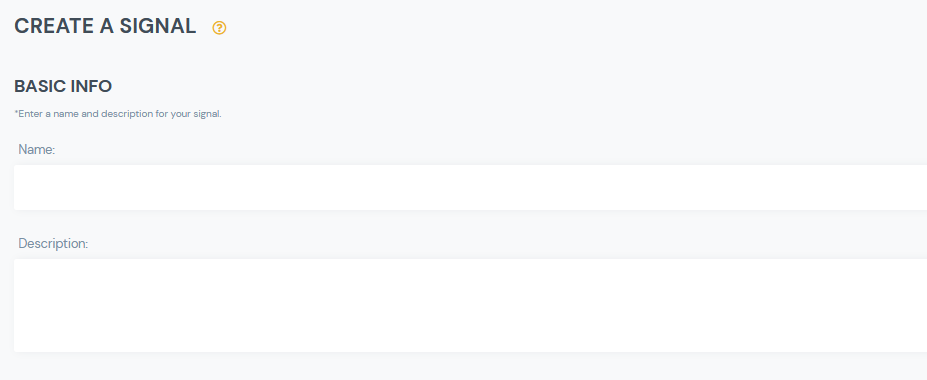

Provide the industry and analysis type. This information is used to recommend features (control datasets) to consider using in your signal.

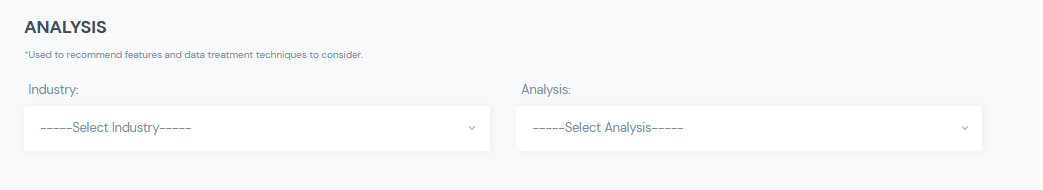

Select the desired output grain. This information will be used to determine the granularity of the signal output for each row in the dataset. You will need to select a Time Grain (Day, Week, Month, etc.) and Geographic grain (City, State, Zip, etc.), as well as the Start and End date of your signal. If you select “No End" date, the signal will always include the most recently available data.

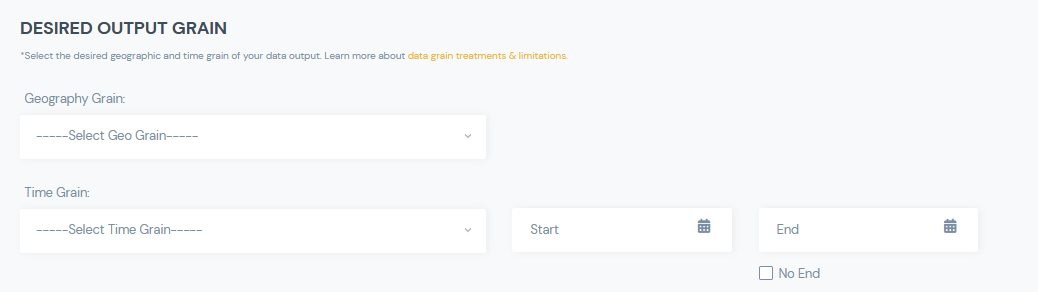

For example, if you select a granularity of Month and Zip, you will get a unique row of data for each month and zip code combination:

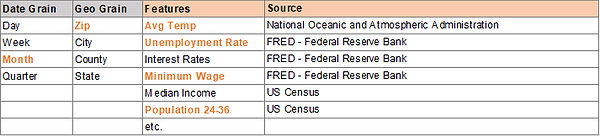

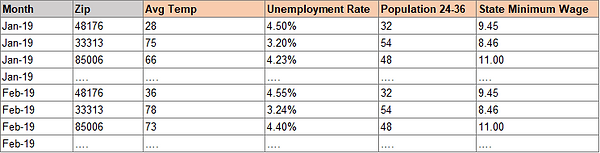

Reference the Ready Signal documentation to learn more about [how geographic and time grains work](https://readysignal.com/data-grains-explained).

### Add and filter features

You will start by filtering what features (control datasets) you want to look at. You can select or deselect any category. You can also enter a keyword that will be used to look for signals with that word or phrase.

Recommendations are shown based on the Industry and Analysis Type you selected. You can change these on this page if you desire. Click explore to see matching results.

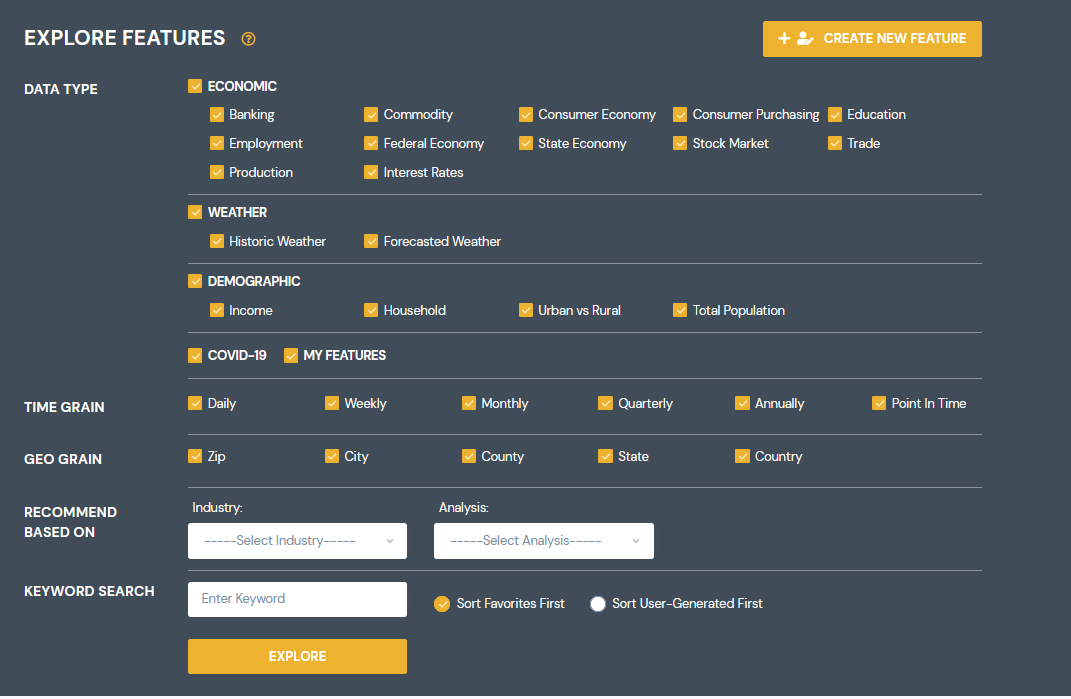

Features that match your criteria will be shown in the results. Any features you had previously favored will be shown at top of the results (yellow stars). Those will be followed by system recommended features, based on the Industry and Analysis Type you selected (grey stars). Other matching features will be shown in alphabetical order.

For each feature you will see its name, the publisher, and the “source” geographic and date grain. The source geo/date grain shows the granularity of the originating data source. The Ready Signal system will transform this data to match your desired output grain. 

You can click on the features name to see more information about that particular feature.

Once you see a feature you want to include, click on the “+” to add it to your signal. Repeat the process till you have added all the desired features to your signal.

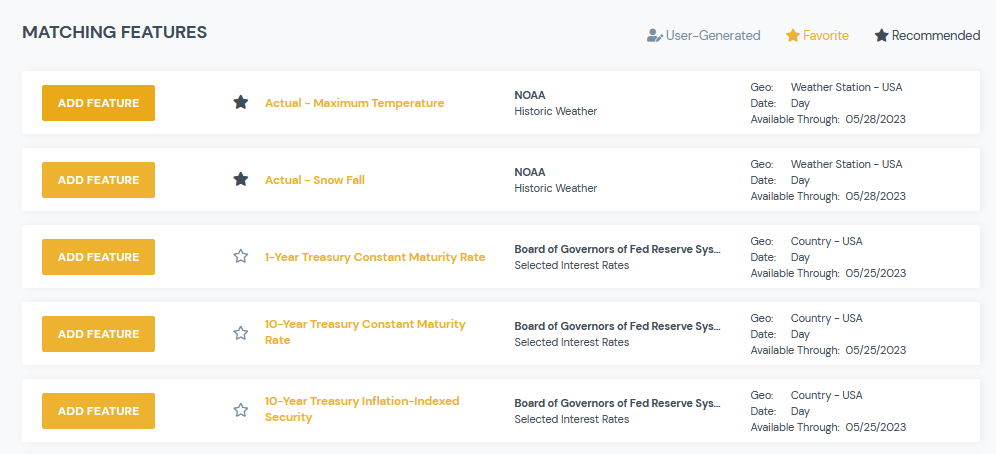

You will see a list of the features you have selected at the bottom of the page. You can click the trash can icon to remove it from your list.

You will be given the option to apply recommended Data Science treatments by default. You can always change this later. So if this is your first signal you can ignore this for now.

Click **Finish**. At this point your signal has been created.
    
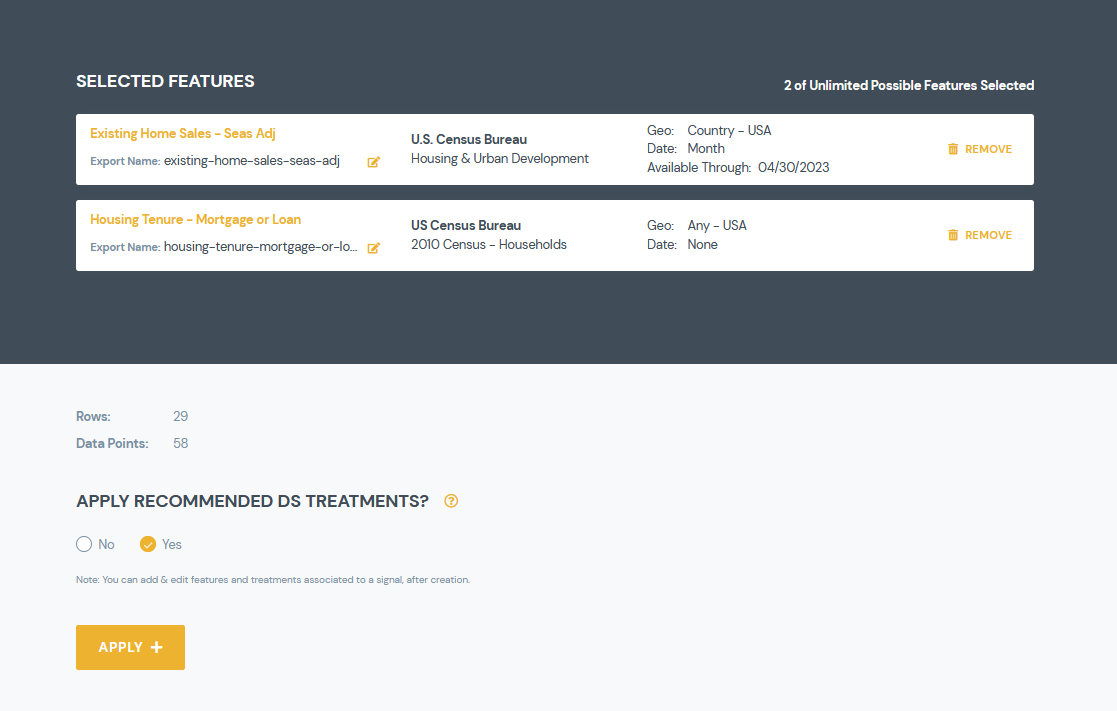

#### What else can you do?

Once your signal is created you can continue to modify it until you are happy and ready to ingest it into your models. You can:

* Apply data science treatments to individual features

* Add, remove, or duplicate features

* Edit basic signal details (name, description, etc.)

* Get an output of your data (Download to CSV or Excel; Connect Live to Domo, R, or Python) 

#### Related documentation
- [Learn about Time & Geo Grain](https://readysignal.com/data-grains-explained)
- [Learn about Data Science Treatments](https://readysignal.com/overview-of-data-science-treatments)
- [Learn about Output Options](https://readysignal.com/how-to-export-your-processed-control-data-signal)

## Explore and edit your signal

When you generate a signal you will recieve a 'signal_id' which you can access via the API using the following cell.

In [ ]:
# Get the signal from Auto Discovery

signal_id = 1694 # Copy the signal ID from Auto Discovery
externalDataSignal = rs.get_signal_pandas(access_token, signal_id)

In [ ]:
# List columns in the dataset
list(externalDataSignal.columns)

['start',
 'end',
 'country',
 'china-us-foreign-exchange-rate_Lag2',
 'sp-500_Lag2',
 'dow-jones-industrial-average-djia',
 'daily-tests-by-state-healthdata_Lag7',
 'effective-federal-funds-rate_Lag7',
 'bank-prime-loan-rate_Lag7',
 'federal-funds-target-range-upper-limit_Lag7',
 '10-year-treasury-inflation-indexed-security_Lag7',
 '3-month-treasury-bill-secondary-market-rate_Lag7',
 '3-month-treasury-constant-maturity-rate_Lag7',
 'us-lumber-price']

In [ ]:
# This API call returns a detailed view of your signal which contains metadata for each feature pulled in
rs.get_signal_details(access_token, signal_id)

{'data': {'id': 1694,
  'name': 'Auto-discovery - US Lumber Price',
  'description': None,
  'desired_geo_grain': 'Country',
  'desired_time_grain': 'Day',
  'start_at': '07/01/2019',
  'end_at': '02/28/2023',
  'created_at': '05/15/2023',
  'updated_at': '05/15/2023',
  'deleted_at': None,
  'company': {'id': 7,
   'chargebee_id': '16BchWS5apkUP1Snu',
   'name': 'RXA',
   'plan_id': 7,
   'plan_value_id': 11,
   'subscription_status': 'active',
   'points_renew_date': '2023-09-22',
   'data_points': 368552750,
   'need_listining_webhook': 0,
   'addon_users': 100,
   'notify_after_processing': 1,
   'enable_forecast': 0,
   'created_at': '2020-07-23 19:12:21',
   'updated_at': '2023-05-15 21:49:33'},
  'user': {'id': 500,
   'company_id': 7,
   'name': 'Jack Claucherty',
   'email': 'jack.claucherty@rxa.io',
   'email_verified_at': None,
   'type': 'admin',
   'active': 'yes',
   'reactivate': 'no',
   'google_id': None,
   'microsoft_id': None,
   'notify_after_processing': 0,
   'cr

### Data Details page

There is a URL in the output above that directly links to the **Data Details** page in the Ready Signal GUI which offers additional insights visualized for each feature. This section outlines how that page works and provides guidance on data science treatments for the features.

Access the **Data Details** page by clicking on the feature name from the [Data Sets page](https://readysignal.com/data/) of the Ready Signal website, or by clicking on the feature name while adding features to a signal in your account.

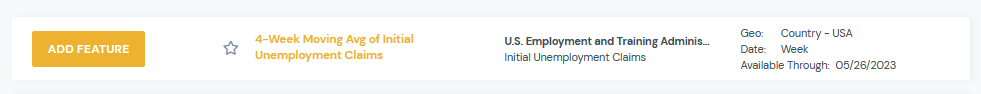

#### Importance

There are a variety of Data Science Treatments you can apply to features within a signal in your Ready Signal account. These treatments can greatly improve the usefulness of your data. *Note that these treatments are applied at the individual feature level.*  

 Each feature offered by Ready Signal undergoes a transformation analysis to determine its suitability to be used in modeling in its raw form. Users can test the data science transformations suggested by adding both the untransformed feature and the feature using the recommended treatments to their signal in order to test its fit and predictive power in their analysis. 

#### Feature specs

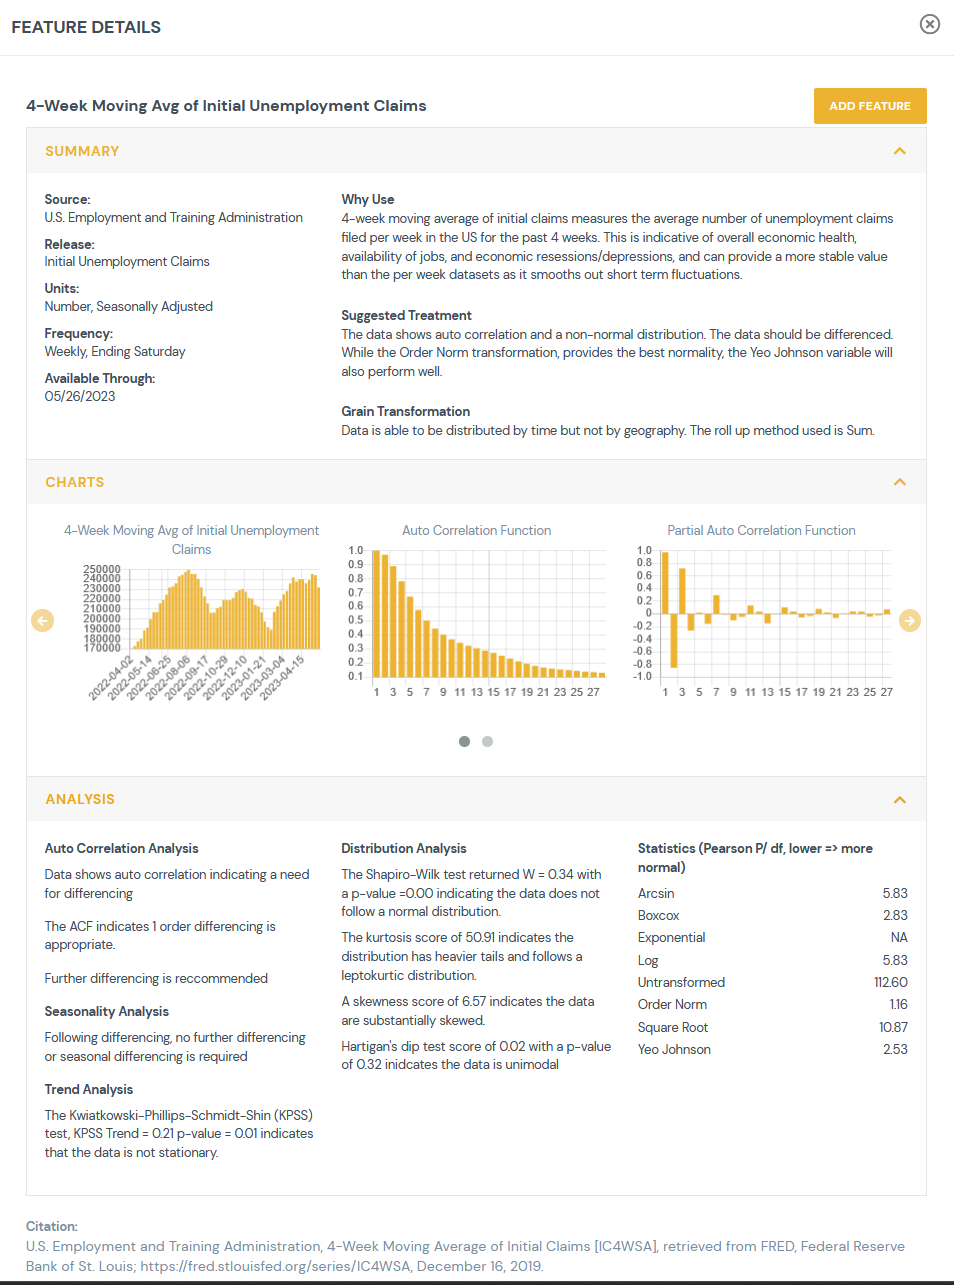

This section provides an overview of the data. Source, release, units, and frequency are provided in order to understand where the data comes from, what form it takes, and how often it is updated. The data is graphed over time for time series data and geographically for point in time data.

The **Why Use** section gives a brief overview of the benefit of using this data stream in analyses.

The **Suggested Treatment** section provides a recommendation of how to best transform the data in order to improve normality. For time series data, it aims to ensure the data is stationary, not autocorrelated, and not seasonally impacted. Details for the suggestions and their rationale are provided below.

#### Time series analysis

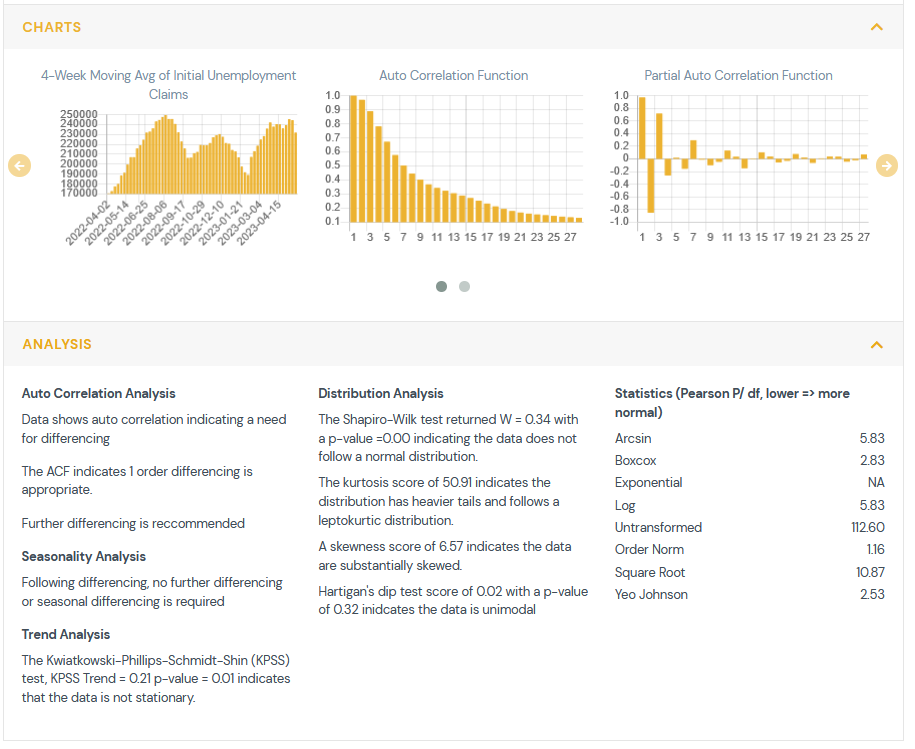

Time series analysis is conducted on features that have repeated measures over time at a set interval. The data is tested for autocorrelation (also known as serial correlation) to determine whether observations are independent over time.

To determine whether prior values of a time series have an influence on the current value, use the autocorrelation function (ACF). The ACF computes the correlation between the current value and previous values in time. The ACF plot shows the correlation between the current value (T) and the K previous values (T-1,T-2,…,T-K).

- When autocorrelation is present, either constant or slowly diminishing across values of K, differencing is recommended.

The partial autocorrelation function (PACF) is the correlation of a lag after the computation of previous lags. This allows the viewer to determine if additional differencing is needed beyond the first order.

- Peaks at intervals representing a year may indicate the need for seasonal differencing.

The time series analysis also displays the autocorrelation function (ACF) after first-order differencing. This indicates the residual correlation after the data has been differenced.

- If the analysis shows sustained autocorrelation, further differencing is required.
- If the autocorrelation is near zero or slightly negative, no further differencing is needed.

The feature is also tested for stationarity. A time series is considered stationary when the mean and variance are constant over time. The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test measures whether the feature is stationary around the mean or linear trend. It decomposes data into a trend component, a random walk, and an error term. The null hypothesis is that the data is stationary. P-values of less than 0.05 indicate the data is not stationary.
This test is used to recommend whether or not the data should be differenced.

#### Seasonality

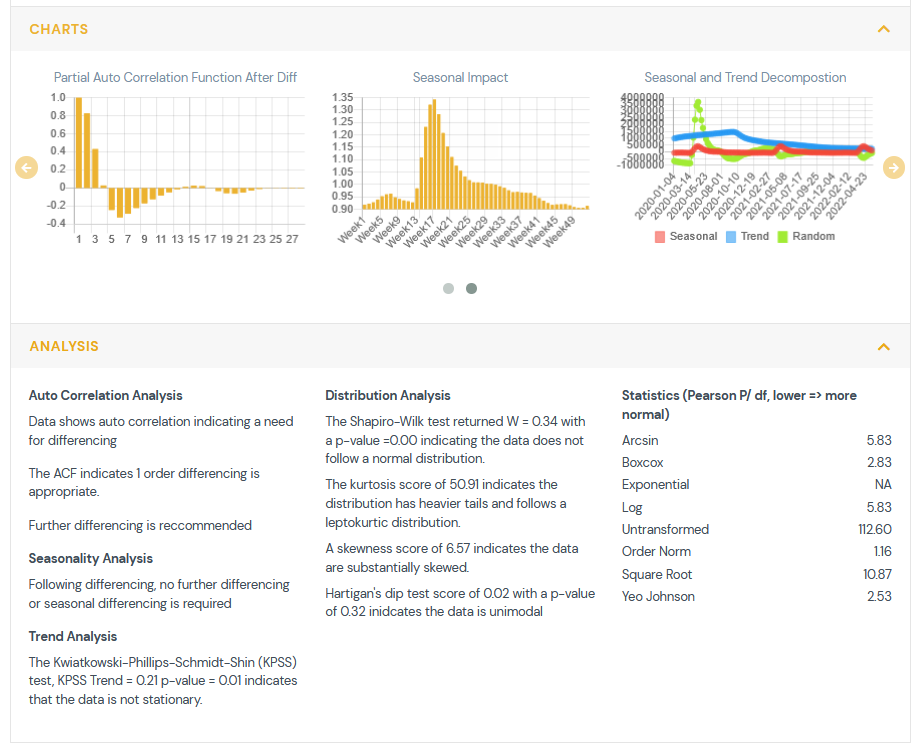

For data that is reported on a quarterly, monthly, weekly, or daily basis, a seasonality analysis is performed. The data is decomposed into a trend component, a seasonal component, and a random component. The trend component is computed through a moving average, while the seasonal component is computed by averaging each time period across years. The remainder becomes the error term.

The multiplicative seasonality is shown as the seasonal impact. If you want to learn more about data transforms, refer to ReadySignal's [data transforms page](https://readysignal.com/overview-of-data-science-treatments).

The seasonality levels are quarterly for quarterly data, monthly for both monthly and daily data, and weekly for weekly data. A seasonal unit root test uses a measure of seasonal strength to recommend whether or not seasonal differencing is required.

#### Normality

Each feature, whether time series or point in time, undergoes a distribution analysis.The Shapiro-Wilk test compares the order distribution of the feature to the expected values of a standard normal distribution. The null hypothesis is that the data is normally distributed. In cases where the p-values are less than 0.05, it is concluded that the data is not normally distributed.

Kurtosis is then computed to measure the thickness of the distribution’s tails relative to the normal distribution. When kurtosis is greater than one, it indicates that the distribution has heavier tails and follows a leptokurtic distribution. When kurtosis is less than negative one, it indicates that the distribution has lighter tails and follows a platykurtic distribution. When kurtosis is between negative one and one, it indicates that the distribution is relatively normal and follows a mesokurtic distribution.

Next, skewness is computed to measure the symmetry of the feature’s distribution. Absolute values greater than 1 indicate substantial skewness.

Hartigan’s dip test is then computed to estimate whether the feature comes from a unimodal distribution. It examines both the feature distribution function and the unimodal distribution function. The null hypothesis is that the data is unimodal. P-values of less than 0.05 indicate that the data is multimodal.

Finally, a series of transformations are tested to determine whether they improve the normality of the data. The Pearson test statistic is calculated across classes that are equiprobable under the hypothesis of normality. The transformation with the lowest Pearson statistic is recommended to improve normality.

### Join Ready Signal data with your time series data

In [ ]:
# Rename the timestamp feature to match the target dataset and remove unwanted features
externalDataSignal = externalDataSignal.rename(columns={'start': date_feature})
externalDataSignal = externalDataSignal.drop(columns=['end','country'])

# Remove the target column if you used Auto Discovery
externalDataSignal = externalDataSignal.drop(columns=[target.lower().replace(' ', '-')])

externalDataSignal[date_feature]= pd.to_datetime(externalDataSignal[date_feature])
ts_forecasting_train[date_feature]= pd.to_datetime(ts_forecasting_train[date_feature])

In [ ]:
# Join Ready Signal data with your time series training data
ts_forecasting_signal_train = ts_forecasting_train.merge(externalDataSignal, on=date_feature, how='left')

In [ ]:
# Upload the dataset to AI Catalog
# This example also uploads the data to a S3 bucket
# ts_forecasting_signal_train = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/autoDisco/DAILYTimeSeriesDatawithReadySignal.csv')

new_dataset = dr.Dataset.upload(ts_forecasting_signal_train)

# Get new dataset ID from the AI Catalog and rename it
new_dataset_id = new_dataset.id
# new_dataset_id = '6462a951214083424ae072bc'
dr.models.Dataset.get(new_dataset_id).modify(name='USLumberPrice_with_ReadySignal')

Dataset(name='data.csv', id='6462a951214083424ae072bc')

## Create a time series project

This section creates a time series project with the dataset created above. For a more in depth walkthrough of creating a time series project, review an [end-to-end time series forecasting workflow](https://community.datarobot.com/t5/ai-accelerators/end-to-end-time-series-demand-forecasting-workflow/td-p/16039).

In [ ]:
# Create a new project using the new training dataset
project_w_rs = dr.Project.create_from_dataset(
    new_dataset_id,
    project_name = 'DAILY Lumber Time Series with ReadySignal'
)

In [ ]:
# Configure the time series project
partition = dr.DatetimePartitioningSpecification(
    datetime_partition_column = date_feature, 
    use_time_series= True
)

### Start modeling

In [ ]:
# Set the project's target and initiate Autopilot
project_w_rs.analyze_and_model(target=target, 
                          partitioning_method=partition,
                          worker_count=-1,
                          mode=dr.AUTOPILOT_MODE.QUICK
                         )

Project(DAILY Lumber Time Series with ReadySignal)

In [ ]:
# Open the project's Leaderboard to monitor the progress in UI
project_w_rs.open_in_browser()

# Wait for the model creation to finish
project_w_rs.wait_for_autopilot()

Please visit: https://app.datarobot.com/projects/6465aacecefe8eb06b229403/models
In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)


In progress: 8, queued: 0 (waited: 4s)


In progress: 8, queued: 0 (waited: 8s)


In progress: 8, queued: 0 (waited: 14s)


In progress: 8, queued: 0 (waited: 27s)


In progress: 8, queued: 0 (waited: 48s)


In progress: 2, queued: 0 (waited: 68s)


In progress: 8, queued: 0 (waited: 88s)


In progress: 4, queued: 0 (waited: 108s)


In progress: 0, queued: 0 (waited: 129s)


In progress: 0, queued: 0 (waited: 149s)


In progress: 0, queued: 0 (waited: 169s)


In progress: 1, queued: 0 (waited: 189s)


In progress: 1, queued: 0 (waited: 210s)


In progress: 1, queued: 0 (waited: 230s)


In progress: 0, queued: 0 (waited: 250s)


In progress: 0, queued: 0 (waited: 271s)


In progress: 0, queued: 0 (waited: 291s)


In progress: 0, queued: 0 (waited: 311s)


In [ ]:
# Create a new project without external ReadySignal features
project_wo_rs = dr.Project.create_from_dataset(
    raw_dataset_id,
    project_name = 'DAILY Lumber Time Series without ReadySignal'
)

# Configure the time series project
partition = dr.DatetimePartitioningSpecification(
    datetime_partition_column = date_feature, 
    use_time_series= True
)

# Set the project's target and initiate Autopilot
project_wo_rs.analyze_and_model(target=target, 
                          partitioning_method=partition,
                          worker_count=-1,
                          mode=dr.AUTOPILOT_MODE.QUICK
                         )

# Open the project's Leaderboard to monitor the progress in UI
project_wo_rs.open_in_browser()

# Wait for the model creation to finish
project_wo_rs.wait_for_autopilot()

Project(DAILY Lumber Time Series with ReadySignal)

In [ ]:
# Report the min of RMSE for all models on Leaderboard when external signal is included
project_w_rs = dr.Project.get(project_id='6465aacecefe8eb06b229403')
model_scores = []
for model in project_w_rs.get_datetime_models():
  model_scores.append(model.metrics['RMSE']['backtesting'])
score_w_rs = [x for x in model_scores if str(x) != 'None']
min(score_w_rs)

52.21865

In [ ]:
# Report the min of RMSE for all models on the Leaderboard when external signal is not included
project_wo_rs = dr.Project.get(project_id='6462aa3d214083424ae072ce')
model_scores = []
for model in project_wo_rs.get_datetime_models():
  model_scores.append(model.metrics['RMSE']['backtesting'])
score_wo_rs = [x for x in model_scores if str(x) != 'None']
min(score_wo_rs)

56.25866

In [ ]:
# Model performance improvement with external signal included measured based on RMSE
'{:.1%}'.format((min(score_wo_rs) - min(score_w_rs))/min(score_wo_rs))

'7.2%'

## Create a scoring dataset with Ready Signal

To use your signal you created to make predictions, you can join the signal with the scoring dataset. For simplification, this example appends 14 new rows without the target to the original training dataset as the scoring dataset. You can use a separate the scoring dataset in your use case. 

In [ ]:
# Read in the scoring dataset from a local file or from the AI Catalog
test_dataset = pd.read_csv('./storage/USLumberPrice.csv')

# test_dataset_id = '6462a7a099f708e3c6450ff5'
# test_dataset = dr.models.Dataset.get(test_dataset_id).get_as_dataframe()
test_dataset[date_feature]= pd.to_datetime(test_dataset[date_feature])

In [ ]:
# This loop appends new rows for forecasting
# This will represent the yellow "forecast rows" in the example above

min_forecast_rows = 1
max_forecast_rows = 14
for i in range(min_forecast_rows,max_forecast_rows+1):
  row = pd.DataFrame({date_feature: test_dataset.loc[len(test_dataset.index)-1][date_feature]+ pd.DateOffset(1)}, index = [len(test_dataset.index)])
  test_dataset = pd.concat([test_dataset,row], ignore_index = True)

In [ ]:
signal_id = 1694
test_signal = rs.get_signal_pandas(access_token, signal_id)
test_signal = test_signal.rename(columns={'start': date_feature})
test_signal = test_signal.drop(columns=['end','country'])

# Remove the target column if you use Auto Discovery
test_signal = test_signal.drop(columns=[target.lower().replace(' ', '-')])
test_signal[date_feature]= pd.to_datetime(test_signal[date_feature])

In [ ]:
test_dataset_rs = test_dataset.merge(test_signal, on=date_feature, how='left')
# test_dataset_rs['Date'] = test_dataset_rs['Date'].dt.strftime('%m/%d/%Y')

### Send the prediction dataset to the best model and return predictions

In [ ]:
dataset_from_path = project_w_rs.upload_dataset(test_dataset_rs)

In [ ]:
predict_job = model.request_predictions(dataset_id=dataset_from_path.id)
predictions = predict_job.get_result_when_complete()
predictions.head()

,row_id,prediction,forecast_distance,forecast_point,timestamp,original_format_timestamp
0,917,401.262884,1,2023-02-28T00:00:00.000000Z,2023-03-01T00:00:00.000000Z,2023-03-01
1,918,406.632298,2,2023-02-28T00:00:00.000000Z,2023-03-02T00:00:00.000000Z,2023-03-02
2,919,396.640381,3,2023-02-28T00:00:00.000000Z,2023-03-03T00:00:00.000000Z,2023-03-03
3,920,434.154206,4,2023-02-28T00:00:00.000000Z,2023-03-04T00:00:00.000000Z,2023-03-04
4,921,458.505377,5,2023-02-28T00:00:00.000000Z,2023-03-05T00:00:00.000000Z,2023-03-05
